# Convexity Counterexamples
This notebook generates counterexamples to the convexity postulate. Specifically, we find Hamiltonians for which the energy as a function of particle number, for charged particles (Coulomb repulsion) is not convex. I.e.,
$$
\eta(N) = E(N+1) - 2 E(N) +E(N-1) <0
$$

Our strategy is to ensure that the $N\pm1$-particle systems have geometries with low Coulomb repulsion (e.g, position them to minimize Coulomb repulsion on a sphere). To do this, we select sites at these geometries; the relative energy of these sites can be adjusted but, alternatively, can be just *chosen* (as a way to set the energy scale). The $N$-particle system will then be quite frustrated, as there are optimal places for $N\pm1$ charged particles, but not $N$.

For small systems we attempt to characterize the solutions quite thoroughly; for larger systems we attempt merely to test for the possible presence of negative convexity.

## $N=5$ (Tetrahedron + Octahedron)
We begin with the $N=5$ case, where we place 6 sites at the vertices of an octahedron (the optimal arrangement for 6 charged particles on a sphere) and 4 sites at the vertices of a tetrahedron (the optimal arrangement for 4 charged particles on a sphere). We choose the octahedral sites to be higher in energy than the tetrahedral sites by one unit, and choose the energy of the tetrahedral sites (setting the arbitrary energy zero) to be -10. 

Specifically, we choose:
$$
\begin{split}
\epsilon_{1} &= -.125 \\
\epsilon_{2} &= -.12362 
\end{split}
$$

The tetrahedral vertices are located at 
$$
\begin{split}
\vec{r}_{11} &= \tfrac{\sqrt{3}}{3} \cdot(1, 1, 1) \\
\vec{r}_{12} &= \tfrac{\sqrt{3}}{3} \cdot(1, -1, -1) \\
\vec{r}_{13} &= \tfrac{\sqrt{3}}{3} \cdot(-1, 1, -1) \\
\vec{r}_{14} &= \tfrac{\sqrt{3}}{3} \cdot(-1, -1, 1) 
\end{split}
$$
and the octahedral vertices at
$$
\begin{split}
\vec{r}_{21} &= (0, 0, 1) \\
\vec{r}_{22} &= (0, 0, -1) \\
\vec{r}_{23} &= (0, 1, 0) \\
\vec{r}_{24} &= (0, -1, 0) \\
\vec{r}_{25} &= (1, 0, 0) \\
\vec{r}_{26} &= (-1, 0, 0) 
\end{split}
$$

These *reference* geometries are on a unit sphere. We will scale them by $R_1$ and $R_2$, respectively.

We have purposely chosen a "generic" notation to emphasize the fact there are really just two groups of points; the framework can be generalized by choosing alternative geometries for the two groups. 

We checked a second configuration, where the tetrahedron was rotated, rather than point through the planes of the tetrahedron. It did not work well (no counterexample found).

In [10]:
import numpy as np
from scipy.spatial.distance import pdist, cdist

def coulomb_repulsion(positions, zeta=1, eps=1e-14):
    """
    Computes the (generalized) Coulomb repulsion energy for a set of positions,
    defined as the sum over all unique pairs of 1 / r**zeta, where r is the
    distance between the points.

    Parameters
    ----------
    positions : array-like, shape (n_points, n_dimensions)
        The positions of the points in space.
    zeta : float, optional
        The exponent in the generalized Coulomb repulsion (default is 1).
    eps : float, optional
        A small threshold to detect coincident points (default is 1e-12).
    Returns
    -------
    float
        The total Coulomb repulsion energy.
    Returns +inf if any pair distance <= eps (coincident points).
    """
    pos = np.asarray(positions, dtype=float)
    n = pos.shape[0]
    if n < 2:
        return 0.0
    d = pdist(pos)                # condensed distances (length n*(n-1)/2)
    if np.any(d <= eps):          # catch coincidences / near-zero distances
        return float("inf")
    # compute sum of 1 / d**zeta
    return float(np.sum(d ** (-zeta)))

# Write a Coulomb repulsion operator that captures the Coulomb repulsion between two different sets of points, positions_1 and positions_2.
def coulomb_repulsion_two_types(positions_1, positions_2, zeta=1, eps=1e-14):
    """
    Computes the (generalized) Coulomb repulsion energy between two sets of positions,
    defined as the sum over all pairs of 1 / r**zeta, where r is the
    distance between points from the two different sets.

    Parameters
    ----------
    positions_1 : array-like, shape (n_points_1, n_dimensions)
        The positions of the first set of points in space.
    positions_2 : array-like, shape (n_points_2, n_dimensions)
        The positions of the second set of points in space.
    zeta : float, optional
        The exponent in the generalized Coulomb repulsion (default is 1).
    eps : float, optional
        A small threshold to detect coincident points (default is 1e-12).
    Returns
    -------
    float
        The total Coulomb repulsion energy between the two sets.
    Returns +inf if any pair distance <= eps (coincident points).
    """
    pos1 = np.asarray(positions_1, dtype=float)
    pos2 = np.asarray(positions_2, dtype=float)
    if pos1.size == 0 or pos2.size == 0:
        return 0.0
    dists = cdist(pos1, pos2)  # (n1, n2)
    if np.any(dists <= eps):
        return float("inf")
    return float(np.sum(dists ** (-zeta)))

In [11]:
# We need to be careful because we can't always assume that all choices of site are equivalent (though it is usually true for N < 5).
from itertools import combinations

def compute_energy(N, positions_1, positions_2, R1, R2, zeta=1,return_positions=False):
    """
    Compute the minimum energy for N particles occupying sites taken from
    a positions_1 and positions_2, where positions_1 has fewer sites than positions_2.
    We also force that the number of particles is at least the number of positions_1.

    Parameters
    ----------
    N : int
        Number of particles.
    positions_1 : list of tuples
        List of positions for the first geometry (e.g., tetrahedron).
    positions_2 : list of tuples
        List of positions for the second geometry (e.g., octahedron).
    R1 : float
        Scale factor for the first geometry.
    R2 : float
        Scale factor for the second geometry.
    zeta : float, optional
        Power of the Coulomb repulsion (default 1 -> 1/r = Coulomb).
    return_positions : bool, optional
        If True, also return the positions of the minimum energy configuration.

    Returns
    -------
    float
        Minimum total energy found over all allowed site selections.
    tuple (float, list of tuples), optional
        If return_positions is True, returns a tuple of (minimum energy, positions).
    """
    # Tetrahedral unit vectors (unit length), energies
    n_1 = len(positions_1)
    n_2 = len(positions_2)

    #Take positions and scale
    positions_1 = [(R1*x, R1*y, R1*z) for (x,y,z) in positions_1]
    positions_2 = [(R2*x, R2*y, R2*z) for (x,y,z) in positions_2]

    if N < 1 or N > n_1+n_2:
        raise ValueError(f"Invalid choice for particle number.")

    min_energy = float("inf")

    # iterate feasible counts the first type of sites.
    for n_occ_1 in range(0, min(n_1, N) + 1):
        n_occ_2 = N - n_occ_1
        # Skip if n_occ_2 is invalid
        if n_occ_2 < 0 or n_occ_2 > n_2:
            continue
        # type 1 sites have energy -10.0, type 2 sites have energy -9.0
        one_electron_energy = n_occ_1 * -.12499 + n_occ_2 * -0.12361

        # look at all type-1 sites in cases they are not all symmetric.
        for type_1_indices in combinations(range(n_1), n_occ_1):
            positions_occ_1 = [positions_1[i] for i in type_1_indices]

            # iterate all choices of type-two sites sites
            for type_2_indices in combinations(range(n_2), n_occ_2):
                positions_occ_2 = [positions_2[i] for i in type_2_indices]
                total_positions = positions_occ_1 + positions_occ_2
                coul = coulomb_repulsion(total_positions, zeta)
                total_energy = one_electron_energy + coul
                if total_energy < min_energy:
                    min_energy = total_energy
                    if return_positions:
                        best_positions = total_positions
    if return_positions:
        return min_energy, best_positions
    else:
        return min_energy

def compute_hardness(N, positions_1, positions_2, R1, R2, zeta=1):
    """
    Compute the hardness eta(N) = E(N+1) - 2 E(N) + E(N-1)
    Parameters
    ----------
    N : int
        Number of particles.
    positions_1 : list of tuples
        List of positions for the first geometry (e.g., tetrahedron).
    positions_2 : list of tuples
        List of positions for the second geometry (e.g., octahedron).
    R1 : float
        Scale factor for the first geometry.
    R2 : float
        Scale factor for the second geometry.
    zeta : float, optional
        Power of the Coulomb repulsion (default 1 -> 1/r = Coulomb).
    Returns
    -------
    float
        The hardness eta(N).
    """

    E_N_plus_1 = compute_energy(N + 1, positions_1, positions_2, R1, R2, zeta)
    E_N = compute_energy(N, positions_1, positions_2, R1, R2, zeta)
    E_N_minus_1 = compute_energy(N - 1, positions_1, positions_2, R1, R2, zeta)
    hardness = E_N_plus_1 + E_N_minus_1 - 2 * E_N

    return hardness

In [12]:
positions_1 = [
        (1.0,  1.0,  1.0),
        (1.0, -1.0, -1.0),
        (-1.0, 1.0, -1.0),
        (-1.0,-1.0,  1.0)
    ]

scale = np.sqrt(3) / 3.0  # Scale factor to inscribe tetrahedron in unit sphere
positions_1 = [(scale*x, scale*y, scale*z) for (x,y,z) in positions_1]

# Octahedron inscribed in unit sphere.
positions_2 = [
        (1.0, 0.0, 0.0),
        (-1.0,0.0, 0.0),
        (0.0, 1.0, 0.0),
        (0.0,-1.0, 0.0),
        (0.0, 0.0, 1.0),
        (0.0, 0.0,-1.0)
    ]

# Minimize the hardness with respect to R1 and R2; also plot the results.
from scipy.optimize import minimize
def objective(params):
    R1, R2 = params
    N=5
    return compute_hardness(N, positions_1, positions_2, R1, R2, zeta=1)

initial_guess = [240, 310]
result = minimize(objective, initial_guess, method='powell',tol=1e-12)
optimal_R1, optimal_R2 = result.x
print(f"Optimal R1: {optimal_R1}, Optimal R2: {optimal_R2}")
print(f"Minimum Hardness: {result.fun}")

initial_guess = [240, 310]
result = minimize(objective, initial_guess, tol=1e-12)
optimal_R1, optimal_R2 = result.x
print(f"Optimal R1: {optimal_R1}, Optimal R2: {optimal_R2}")
print(f"Minimum Hardness: {result.fun}")

Optimal R1: 241.06821394756832, Optimal R2: 309.99999999995
Minimum Hardness: -0.0010153889410648986
Optimal R1: 240.8233849457912, Optimal R2: 309.5530141055784
Minimum Hardness: -0.001015397684785091


In [13]:
# Tetrahedron. I'll scale it in the next loop so it's inscribed in the unit sphere.
positions_1 = [
        (1.0,  1.0,  1.0),
        (1.0, -1.0, -1.0),
        (-1.0, 1.0, -1.0),
        (-1.0,-1.0,  1.0)
    ]

scale = np.sqrt(3) / 3.0  # Scale factor to inscribe tetrahedron in unit sphere
positions_1 = [(scale*x, scale*y, scale*z) for (x,y,z) in positions_1]

# Octahedron inscribed in unit sphere.
positions_2 = [
        (1.0, 0.0, 0.0),
        (-1.0,0.0, 0.0),
        (0.0, 1.0, 0.0),
        (0.0,-1.0, 0.0),
        (0.0, 0.0, 1.0),
        (0.0, 0.0,-1.0)
    ]

optimal_R1 = 240.82338494329125
optimal_R2 =  309.55301409181493
energy_list = []
hardness_list = []

print(compute_energy(1, positions_1, positions_2, optimal_R1, optimal_R2, zeta=1, return_positions=True))
for N in range(2,10):
    energy, positions = compute_energy(N, positions_1, positions_2, optimal_R1, optimal_R2, zeta=1, return_positions=True)
    hardness = compute_hardness(N, positions_1, positions_2, optimal_R1, optimal_R2, zeta=1)
    print(f"N={N}, Min Energy={energy}, Positions={positions}, Hardness={hardness}")
    energy_list.append(energy)
    hardness_list.append(hardness)

print(energy_list)
print(hardness_list)

for N in range(1,11):
    energy_11 = compute_energy(N, positions_1, positions_2, optimal_R1, optimal_R2, zeta=1, return_positions=False)
    print(f"N={N}, Min Energy={energy_11}")



(-0.12499, [(139.03944612416606, 139.03944612416606, 139.03944612416606)])
N=2, Min Energy=-0.24743717204398571, Positions=[(139.03944612416606, 139.03944612416606, 139.03944612416606), (139.03944612416606, -139.03944612416606, -139.03944612416606)], Hardness=0.002542827956014293
N=3, Min Energy=-0.36734151613195715, Positions=[(139.03944612416606, 139.03944612416606, 139.03944612416606), (139.03944612416606, -139.03944612416606, -139.03944612416606), (-139.03944612416606, 139.03944612416606, -139.03944612416606)], Hardness=0.0025428279560143485
N=4, Min Energy=-0.4847030322639142, Positions=[(139.03944612416606, 139.03944612416606, 139.03944612416606), (139.03944612416606, -139.03944612416606, -139.03944612416606), (-139.03944612416606, 139.03944612416606, -139.03944612416606), (-139.03944612416606, -139.03944612416606, 139.03944612416606)], Hardness=0.00551927923799389
N=5, Min Energy=-0.5965452691578773, Positions=[(139.03944612416606, 139.03944612416606, 139.03944612416606), (139.0

## $N=7$ (Cube + Octahedron)

In [14]:
positions_1 = [
        (1.0, 0.0, 0.0),
        (-1.0,0.0, 0.0),
        (0.0, 1.0, 0.0),
        (0.0,-1.0, 0.0),
        (0.0, 0.0, 1.0),
        (0.0, 0.0,-1.0)]

# Cube.
positions_2 = [(1.0, 1.0, 1.0),
                (1.0, 1.0, -1.0),
                (1.0, -1.0, 1.0),
                (1.0, -1.0, -1.0),
                (-1.0, 1.0, 1.0),
                (-1.0, 1.0, -1.0),
                (-1.0, -1.0, 1.0),
                (-1.0, -1.0, -1.0)]

scale = np.sqrt(3) / 3.0  # Scale factor to inscribe cube in unit sphere
positions_2 = [(scale*x, scale*y, scale*z) for (x,y,z) in positions_2]


def compute_energy_z_theta(N, positions_1, positions_2, R1, R2, z1 = 1.0, z2 = 1.0, theta_1 = 0.0, theta_2 = 0.0, zeta=1,return_positions=False):
    """
    Compute the minimum energy for N particles occupying sites taken from
    a positions_1 and positions_2, where positions_1 has fewer sites than positions_2.
    We also force that the number of particles is at least the number of positions_1.

    This more general function allows for scaling on the z axis too.

    Parameters
    ----------
    N : int
        Number of particles.
    positions_1 : list of tuples
        List of positions for the first geometry (e.g., tetrahedron).
    positions_2 : list of tuples
        List of positions for the second geometry (e.g., octahedron).
    R1 : float
        Scale factor for the first geometry.
    R2 : float
        Scale factor for the second geometry.
    z1 : float
        Scale factor for the z coordinate of the first geometry. Only used
        if the z point is different from +/- 1.
    z2 : float
        Scale factor for the z coordinate of the second geometry. Only used
        if the z point is different from +/- 1.
    theta_1 : float
        Rotation angle (in radians) around the z-axis for the top plane.
    theta_2 : float
        Rotation angle (in radians) around the z-axis for the bottom plane.
    zeta : float, optional
        Power of the Coulomb repulsion (default 1 -> 1/r = Coulomb).
    return_positions : bool, optional
        If True, also return the positions of the minimum energy configuration.

    Returns
    -------
    float
        Minimum total energy found over all allowed site selections.
    tuple (float, list of tuples), optional
        If return_positions is True, returns a tuple of (minimum energy, positions).
    """
    # Tetrahedral unit vectors (unit length), energies
    n_1 = len(positions_1)
    n_2 = len(positions_2)

    # Adjust z-scaling only for points whose z is not ±1 (within a small tolerance),
    # then renormalize each point to the unit sphere, and finally apply R1/R2.
    tol = 1e-12

    def _scale_z_and_normalize(pts, zscale):
        out = []
        for (x, y, z) in pts:
            # scale z only if not ±1
            if zscale != 1.0 and not np.isclose(abs(z), 1.0, atol=tol):
                z = z * zscale
            # normalize to unit sphere
            v = np.array([x, y, z], dtype=float)
            n = np.linalg.norm(v)
            v /= n
            out.append(tuple(v))
        return out

    positions_1 = _scale_z_and_normalize(positions_1, z1)
    positions_2 = _scale_z_and_normalize(positions_2, z2)

    #Then scale by R1 and R2
    positions_1 = [(R1*x, R1*y, R1*z) for (x,y,z) in positions_1]
    positions_2 = [(R2*x, R2*y, R2*z) for (x,y,z) in positions_2]

    # Apply rotations.
    def rotate_z(point, theta):
        x, y, z = point
        x_rot = x * np.cos(theta) - y * np.sin(theta)
        y_rot = x * np.sin(theta) + y * np.cos(theta)
        return (x_rot, y_rot, z)
    # Rotation positions_2 by theta_1 if z>0 and not z=1;
    # Rotate positions_2 by theta_2 if z<0 and not z=-1.
    rotated_positions_2 = []
    for (x,y,z) in positions_2:
        if z > tol and not np.isclose(z, 1.0, atol=tol):
            rotated_positions_2.append(rotate_z((x,y,z), theta_1))
        elif z < -tol and not np.isclose(z, -1.0, atol=tol):
            rotated_positions_2.append(rotate_z((x,y,z), theta_2))
        else:
            rotated_positions_2.append((x,y,z))
    positions_2 = rotated_positions_2

    # if N < n_1 or N > n_1+n_2:
    #     raise ValueError(f"Invalid choice for particle number.")

    min_energy = float("inf")

    # iterate feasible counts the first type of sites.
    for n_occ_1 in range(0,min(N,n_1)+1):
        n_occ_2 = N - n_occ_1
        # Skip if n_occ_2 is invalid
        if n_occ_2 < 0 or n_occ_2 > n_2:
            continue
        # type 1 sites have energy -10.0, type 2 sites have energy -9.0
        one_electron_energy = n_occ_1 * -.12499 + n_occ_2 * -0.12361

        # look at all type-1 sites in cases they are not all symmetric.
        for type_1_indices in combinations(range(n_1), n_occ_1):
            positions_occ_1 = [positions_1[i] for i in type_1_indices]

            # iterate all choices of type-two sites sites
            for type_2_indices in combinations(range(n_2), n_occ_2):
                positions_occ_2 = [positions_2[i] for i in type_2_indices]
                total_positions = positions_occ_1 + positions_occ_2
                coul = coulomb_repulsion(total_positions, zeta)
                total_energy = one_electron_energy + coul
                if total_energy < min_energy:
                    min_energy = total_energy
                    if return_positions:
                        best_positions = total_positions
    if return_positions:
        return min_energy, best_positions
    else:
        return min_energy

def compute_hardness_z_theta(N, positions_1, positions_2, R1, R2, z1, z2, theta_1, theta_2, zeta=1):
    """
    Compute the hardness eta(N) = E(N+1) - 2 E(N) + E(N-1)
    Parameters
    ----------
    N : int
        Number of particles.
    positions_1 : list of tuples
        List of positions for the first geometry (e.g., tetrahedron).
    positions_2 : list of tuples
        List of positions for the second geometry (e.g., octahedron).
    R1 : float
        Scale factor for the first geometry.
    R2 : float
        Scale factor for the second geometry.
    z1 : float
        Scale factor for the z coordinate of the first geometry. Only used
        if the z point is different from +/- 1.
    z2 : float
        Scale factor for the z coordinate of the sec
    zeta : float, optional
        Power of the Coulomb repulsion (default 1 -> 1/r = Coulomb).
    Returns
    -------
    float
        The hardness eta(N).
    """

    E_N_plus_1 = compute_energy_z_theta(N + 1, positions_1, positions_2, R1, R2, z1, z2, theta_1, theta_2, zeta)
    E_N = compute_energy_z_theta(N, positions_1, positions_2, R1, R2, z1, z2, theta_1, theta_2, zeta)
    E_N_minus_1 = compute_energy_z_theta(N - 1, positions_1, positions_2, R1, R2, z1, z2, theta_1, theta_2, zeta)
    hardness = E_N_plus_1 + E_N_minus_1 - 2 * E_N

    return hardness

In [15]:
from scipy.optimize import minimize
def objective_ztheta(params):
    R1, R2, z1, z2, theta1, theta2 = params
    N=7
    return compute_hardness_z_theta(N, positions_1, positions_2, R1, R2, z1, z2, theta1, theta2, zeta=1)

initial_guess = [72, 76, 1.0, 0.9230,  0.226376, 0.225376]
result = minimize(objective_ztheta, initial_guess, method='powell',tol=1e-12)
optimal_R1, optimal_R2, optimal_z1, optimal_z2, optimal_theta_1, optimal_theta_2 = result.x
print(f"Optimal R1: {optimal_R1}, Optimal R2: {optimal_R2}")
print(f"Optimal z1: {optimal_z1}, Optimal z2: {optimal_z2}")
print(f"Optimal theta_1: {optimal_theta_1}, Optimal theta_2: {optimal_theta_2}")
print(f"Minimum Hardness: {result.fun}")

initial_guess = [1e-11, 9.865e-12, 1.0, 0.9230,  0.226376, 0.225376]
result = minimize(objective_ztheta, initial_guess, method='powell',tol=1e-12)
optimal_R1, optimal_R2, optimal_z1, optimal_z2, optimal_theta_1, optimal_theta_2 = result.x
print(f"Optimal R1: {optimal_R1}, Optimal R2: {optimal_R2}")
print(f"Optimal z1: {optimal_z1}, Optimal z2: {optimal_z2}")
print(f"Optimal theta_1: {optimal_theta_1}, Optimal theta_2: {optimal_theta_2}")
print(f"Minimum Hardness: {result.fun}")

Optimal R1: 73.25231058401462, Optimal R2: 76.00000000003214
Optimal z1: 1.0, Optimal z2: 0.923
Optimal theta_1: 0.2165065301112074, Optimal theta_2: 0.2165065315668169
Minimum Hardness: -0.0020090136008545922
Optimal R1: 1e-11, Optimal R2: 9.865e-12
Optimal z1: 1.0, Optimal z2: 0.923044848133407
Optimal theta_1: 0.22537729436654652, Optimal theta_2: 0.22537600378956885
Minimum Hardness: -3318616572.8896484


In [16]:
# Octahedron inscribed in unit sphere.
positions_1 = [
        (1.0, 0.0, 0.0),
        (-1.0,0.0, 0.0),
        (0.0, 1.0, 0.0),
        (0.0,-1.0, 0.0),
        (0.0, 0.0, 1.0),
        (0.0, 0.0,-1.0)]

# Cube.
positions_2 = [(1.0, 1.0, 1.0),
                (1.0, 1.0, -1.0),
                (1.0, -1.0, 1.0),
                (1.0, -1.0, -1.0),
                (-1.0, 1.0, 1.0),
                (-1.0, 1.0, -1.0),
                (-1.0, -1.0, 1.0),
                (-1.0, -1.0, -1.0)]

scale = np.sqrt(3) / 3.0  # Scale factor to inscribe cube in unit sphere
positions_2 = [(scale*x, scale*y, scale*z) for (x,y,z) in positions_2]

optimal_R1 = 73.266
optimal_R2 = 76.002
optimal_z1 = 1.0
optimal_z2 = 0.923
optimal_theta_1 = 0.223
optimal_theta_2 = 0.223

energy_1 = compute_energy_z_theta(1, positions_1, positions_2, optimal_R1, optimal_R2, optimal_z1, optimal_z2, optimal_theta_1, optimal_theta_2, zeta=1, return_positions=True)
print(energy_1)

energy_list, hardness_list, = [], []

for N in range(2,13):
    energy_14, positions_14 = compute_energy_z_theta(N, positions_1, positions_2, optimal_R1, optimal_R2, optimal_z1, optimal_z2, optimal_theta_1, optimal_theta_2, zeta=1, return_positions=True)
    print(f"N={N}, Min Energy={energy_14}, Positions={positions_14}")
    hardness_14 = compute_hardness_z_theta(N, positions_1, positions_2, optimal_R1, optimal_R2, optimal_z1, optimal_z2, optimal_theta_1, optimal_theta_2, zeta=1)
    print(f"N={N}, Hardness={hardness_14}")
    #Store energy and positions in a numpy array or list as needed
    energy_list.append(energy_14)
    hardness_list.append(hardness_14)

print ("Energies:", energy_list)
print ("Hardnesses:", hardness_list)
for N in range(1,15):
    energy_15 = compute_energy_z_theta(N, positions_1, positions_2, optimal_R1, optimal_R2, optimal_z1, optimal_z2, optimal_theta_1, optimal_theta_2, zeta=1, return_positions=False)
    print(f"N={N}, Min Energy={energy_15}")

(-0.12499, [(73.266, 0.0, 0.0)])
N=2, Min Energy=-0.2431555520978353, Positions=[(73.266, 0.0, 0.0), (-73.266, 0.0, 0.0)]
N=2, Hardness=0.012203188769833728
N=3, Min Energy=-0.34911791542583687, Positions=[(0.0, 0.0, 73.266), (33.93706373592093, 53.84311115761814, -41.539127215824095), (-33.93706373592093, -53.84311115761814, -41.539127215824095)]
N=3, Hardness=0.007374081673967692
N=4, Min Energy=-0.44770619707987075, Positions=[(73.266, 0.0, 0.0), (-73.266, 0.0, 0.0), (0.0, 73.266, 0.0), (0.0, -73.266, 0.0)]
N=4, Hardness=0.012203188769833617
N=5, Min Energy=-0.534091289964071, Positions=[(73.266, 0.0, 0.0), (-73.266, 0.0, 0.0), (0.0, 73.266, 0.0), (0.0, -73.266, 0.0), (0.0, 0.0, 73.266)]
N=5, Hardness=0.006824447902164632
N=6, Min Energy=-0.6136519349461065, Positions=[(73.266, 0.0, 0.0), (-73.266, 0.0, 0.0), (0.0, 73.266, 0.0), (0.0, -73.266, 0.0), (0.0, 0.0, 73.266), (0.0, 0.0, -73.266)]
N=6, Hardness=0.023001269124833357
N=7, Min Energy=-0.6702113108033085, Positions=[(33.9370637

Note that only the $q=-13$ and $q=-14$ charge states of the polyanions are unbound.

## Plotting
Plotting functions are moved to the end so it doesn't slow down the more computational part of the notebook.

-0.0010152060594894596


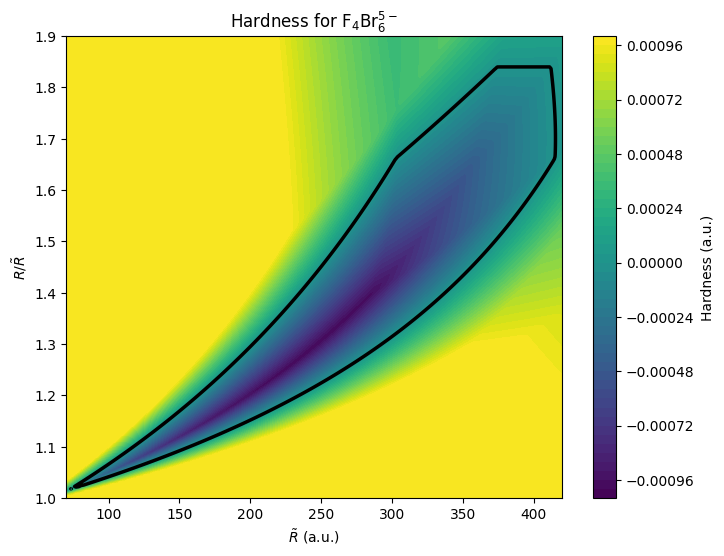

In [17]:

# Tetrahedron. I'll scale it in the next loop so it's inscribed in the unit sphere.
positions_1 = [
        (1.0,  1.0,  1.0),
        (1.0, -1.0, -1.0),
        (-1.0, 1.0, -1.0),
        (-1.0,-1.0,  1.0)
    ]

scale = np.sqrt(3) / 3.0  # Scale factor to inscribe tetrahedron in unit sphere
positions_1 = [(scale*x, scale*y, scale*z) for (x,y,z) in positions_1]

# Octahedron inscribed in unit sphere.
positions_2 = [
        (1.0, 0.0, 0.0),
        (-1.0,0.0, 0.0),
        (0.0, 1.0, 0.0),
        (0.0,-1.0, 0.0),
        (0.0, 0.0, 1.0),
        (0.0, 0.0,-1.0)
    ]

# Plot hardness vs R1 (x-axis) and R2/R1 (y-axis)
import numpy as np
import matplotlib.pyplot as plt

N = 5

R1_values = np.linspace(70, 420, 200)
ratio_values = np.linspace(1.0, 1.9, 200)  # R2/R1

hardness_values = np.zeros((len(R1_values), len(ratio_values)))
for i, R1 in enumerate(R1_values):
    for j, ratio in enumerate(ratio_values):
        # R2/R1 = ratio => R2 = ratio * R1
        R2 = ratio * R1
        hardness_values[i, j] = compute_hardness(N, positions_1, positions_2, R1, R2, zeta=1)
        # after filling hardness_values


print(hardness_values.min())
hardness_values = np.clip(hardness_values, None, 0.001)
R1_grid, ratio_grid = np.meshgrid(R1_values, ratio_values, indexing='ij')

fig, ax = plt.subplots(figsize=(8, 6))

# filled contour
cf = ax.contourf(R1_grid, ratio_grid, hardness_values, levels=50, cmap='viridis')

# colorbar
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label('Hardness (a.u.)')

# draw bold zero contour on top (only the zero level), if present
vmin, vmax = np.nanmin(hardness_values), np.nanmax(hardness_values)
if vmin <= 0.0 <= vmax:
    ax.contour(
        R1_grid, ratio_grid, hardness_values,
        levels=[0.0],
        colors='k',
        linewidths=2.5,
        linestyles='-',
        zorder=10
    )

ax.set_xlabel(r'$\tilde{R}$ (a.u.)')
ax.set_ylabel(r'$R / \tilde{R}$')
ax.set_title(r'Hardness for $\text{F}_4\text{Br}_6^{5-}$')

plt.show()


In [ ]:
positions_1 = [
        (1.0, 0.0, 0.0),
        (-1.0,0.0, 0.0),
        (0.0, 1.0, 0.0),
        (0.0,-1.0, 0.0),
        (0.0, 0.0, 1.0),
        (0.0, 0.0,-1.0)]

# Cube.
positions_2 = [(1.0, 1.0, 1.0),
                (1.0, 1.0, -1.0),
                (1.0, -1.0, 1.0),
                (1.0, -1.0, -1.0),
                (-1.0, 1.0, 1.0),
                (-1.0, 1.0, -1.0),
                (-1.0, -1.0, 1.0),
                (-1.0, -1.0, -1.0)]

scale = np.sqrt(3) / 3.0  # Scale factor to inscribe cube in unit sphere
positions_2 = [(scale*x, scale*y, scale*z) for (x,y,z) in positions_2]

# Plot hardness vs R1 (x-axis) and R2/R1 (y-axis)
import numpy as np
import matplotlib.pyplot as plt

N = 7

R1_values = np.linspace(0.01, 525, 100)
ratio_values = np.linspace(0.975, 1.525, 100)  # R2/R1

hardness_values = np.zeros((len(R1_values), len(ratio_values)))
for i, R1 in enumerate(R1_values):
    for j, ratio in enumerate(ratio_values):
        # R2/R1 = ratio => R2 = ratio * R1
        R2 = ratio * R1
        hardness_values[i, j] = compute_hardness_z_theta(N, positions_1, positions_2, R1, R2, z1=1.0, z2=0.9230, theta_1=.225376, theta_2 = .225376, zeta=1)
        hardness_values_neg = np.minimum(hardness_values, 0.0)

R1_grid, ratio_grid = np.meshgrid(R1_values, ratio_values, indexing='ij')

fig, ax = plt.subplots(figsize=(8, 6))
print(hardness_values.min())
hardness_values = np.clip(hardness_values, -.0025, 0.0025)

# filled contour
cf = ax.contourf(R1_grid, ratio_grid, hardness_values, levels=50, cmap='viridis')

# colorbar
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label('Hardness (a.u.)')

# draw bold zero contour on top (only the zero level), if present
vmin, vmax = np.nanmin(hardness_values), np.nanmax(hardness_values)
if vmin <= 0.0 <= vmax:
    ax.contour(
        R1_grid, ratio_grid, hardness_values,
        levels=[0.0],
        colors='k',
        linewidths=2.5,
        linestyles='-',
        zorder=10
    )

ax.set_xlabel(r'$\tilde{R}$ (a.u.)')
ax.set_ylabel(r'$R / \tilde{R}$')
ax.set_title(r'Hardness for $\text{F}_6\text{Br}_8^{7-}$')

plt.show()

-0.0010152060594894596


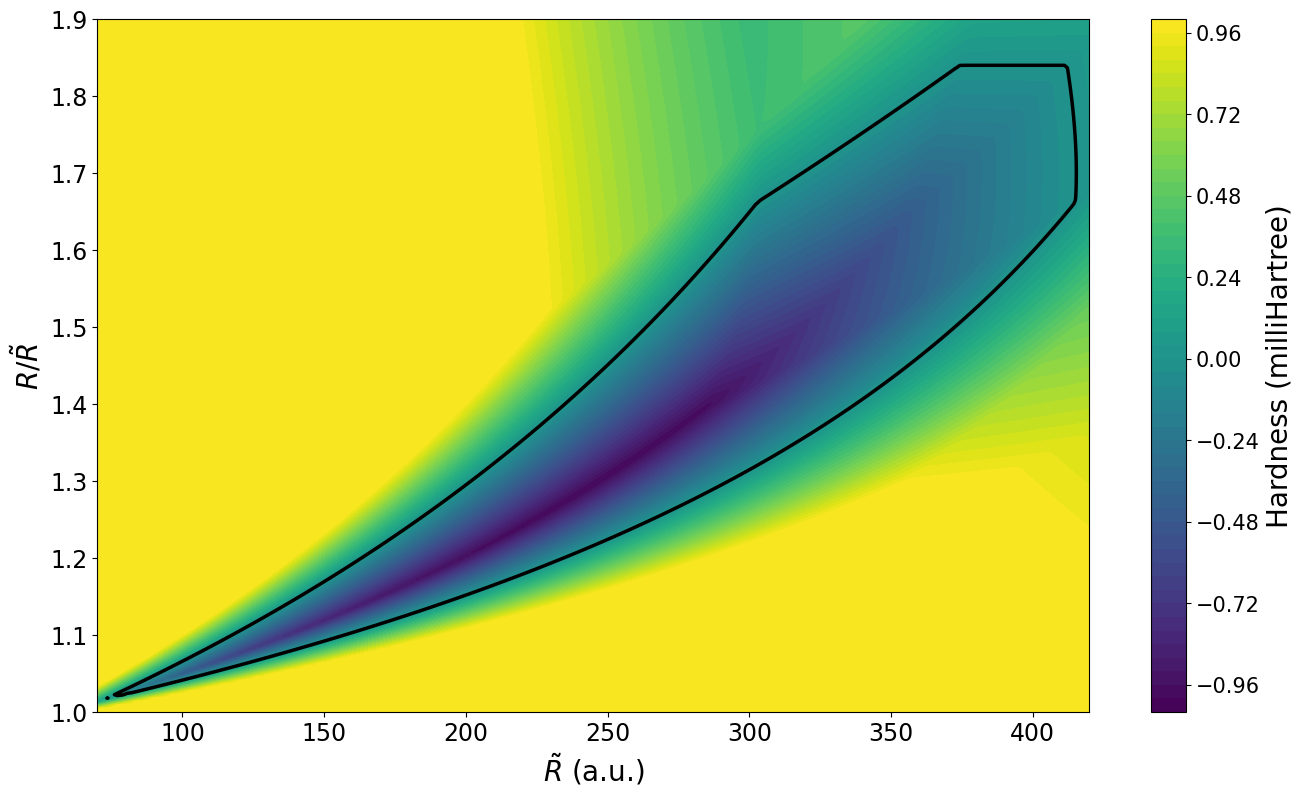

In [ ]:
# For TOC graphic

# Tetrahedron. I'll scale it in the next loop so it's inscribed in the unit sphere.
positions_1 = [
        (1.0,  1.0,  1.0),
        (1.0, -1.0, -1.0),
        (-1.0, 1.0, -1.0),
        (-1.0,-1.0,  1.0)
    ]

scale = np.sqrt(3) / 3.0  # Scale factor to inscribe tetrahedron in unit sphere
positions_1 = [(scale*x, scale*y, scale*z) for (x,y,z) in positions_1]

# Octahedron inscribed in unit sphere.
positions_2 = [
        (1.0, 0.0, 0.0),
        (-1.0,0.0, 0.0),
        (0.0, 1.0, 0.0),
        (0.0,-1.0, 0.0),
        (0.0, 0.0, 1.0),
        (0.0, 0.0,-1.0)
    ]

# Plot hardness vs R1 (x-axis) and R2/R1 (y-axis)
import numpy as np
import matplotlib.pyplot as plt

N = 5

R1_values = np.linspace(70, 420, 200)
ratio_values = np.linspace(1.0, 1.9, 200)  # R2/R1

hardness_values = np.zeros((len(R1_values), len(ratio_values)))
for i, R1 in enumerate(R1_values):
    for j, ratio in enumerate(ratio_values):
        # R2/R1 = ratio => R2 = ratio * R1
        R2 = ratio * R1
        hardness_values[i, j] = compute_hardness(N, positions_1, positions_2, R1, R2, zeta=1)
        # after filling hardness_values


print(hardness_values.min())
hardness_values = np.clip(hardness_values, None, 0.001)*1000.0  # convert to milliHartree
R1_grid, ratio_grid = np.meshgrid(R1_values, ratio_values, indexing='ij')

fig, ax = plt.subplots(figsize=(16, 9))

# filled contour
cf = ax.contourf(R1_grid, ratio_grid, hardness_values, levels=50, cmap='viridis')


# draw bold zero contour on top (only the zero level), if present
vmin, vmax = np.nanmin(hardness_values), np.nanmax(hardness_values)
if vmin <= 0.0 <= vmax:
    ax.contour(
        R1_grid, ratio_grid, hardness_values,
        levels=[0.0],
        colors='k',
        linewidths=2.5,
        linestyles='-',
        zorder=10
    )

# colorbar
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label('Hardness (milliHartree)', fontsize=20)
cbar.ax.tick_params(labelsize=15)

# axis labels and title with larger fonts
ax.set_xlabel(r'$\tilde{R}$ (a.u.)', fontsize=20)
ax.set_ylabel(r'$R / \tilde{R}$', fontsize=20)
#ax.set_title(r'Hardness for $\text{F}_4\text{Br}_6^{5-}$', fontsize=16)

# increase tick label size
ax.tick_params(axis='both', which='major', labelsize=17)

# ax.set_xlabel(r'$\tilde{R}$ (a.u.)')
# ax.set_ylabel(r'$R / \tilde{R}$')
# %ax.set_title(r'Hardness for $\text{F}_4\text{Br}_6^{5-}$')

plt.show()


In [ ]:
# This tests the "easy ratios" for the square prism. The hardness is a touch higher, so it isn't optimal. But it is very close.

positions_1 = [
        (1.0,  1.0,  1.0),
        (1.0, -1.0, -1.0),
        (-1.0, 1.0, -1.0),
        (-1.0,-1.0,  1.0)
    ]

# Cube.
a = np.sqrt(1/5)
b = np.sqrt(1/2)
c = np.sqrt(3/10)

positions_2 = [(a, b, c),
                (a, b, -c),
                (b,-a, c),
                (b,-a, -c),
                (-a, -b, c),
                (-a, -b, -c),
                (-b,a, c),
                (-b,a, -c)]

optimal_R1 = 73.266
optimal_R2 = 76.002
N=7
compute_hardness(7,positions_1=positions_1, positions_2=positions_2, R1=optimal_R1, R2=optimal_R2, zeta=1)

-0.0020185418562295165